## Simulation for different kernels with different parameters

This code is made base on the example 'Classifier comparision' of scikit-learn at http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors       import ListedColormap
from sklearn.metrics         import accuracy_score, roc_auc_score
from sklearn.datasets        import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import MinMaxScaler
from sklearn.svm             import SVC

# Get the mesh grid from a plot
def create_mesh(ax, xlim = None, ylim = None):
    if xlim is None:
      xlim, ylim = ax.get_xlim(), ax.get_ylim()
    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 100)
    yy = np.linspace(ylim[0], ylim[1], 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    return XX, YY, xy

def get_xlim(data):
  X_list, y_list = data
  lim_x0 = [np.min(X_list[:, 0]), np.max(X_list[:, 0])]
  lim_x1 = [np.min(X_list[:, 1]), np.max(X_list[:, 1])]
  return lim_x0, lim_x1

## We first create the data

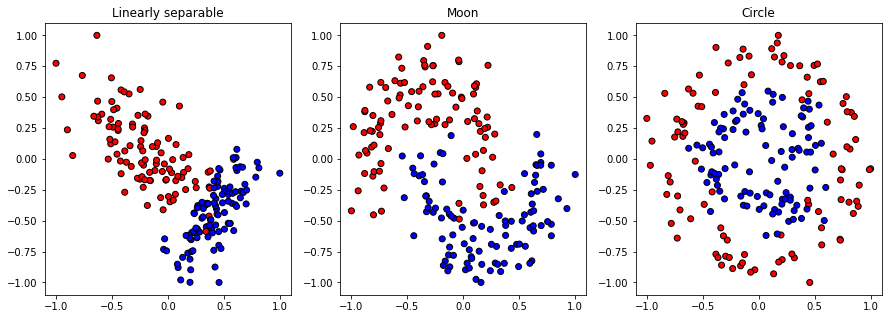

In [2]:
# We first create the datasets
# Create linearly separatable data
X, y = make_classification(n_samples=200, n_features=2, n_redundant=0,
                           n_informative=2, n_clusters_per_class=1,
                           random_state=8, flip_y=0)

rng = np.random.RandomState(2)
X += 1 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

# Create 3 datasets contain separable/non-separable datas
datasets  = [linearly_separable, 
             make_moons(n_samples=200, noise=0.2, random_state=5),
             make_circles(n_samples=200, noise=0.15, factor=0.5, random_state=42)]
scaler = MinMaxScaler()
datasets = [((scaler.fit_transform(dataset[0]) - 0.5) * 2, dataset[1])
            for dataset in datasets]

xlims     = [([-1.5, 1.5], [-1.5, 1.5]) for dataset in datasets]
datanames = ['Linearly separable', 'Moon', 'Circle']

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for idx, data in enumerate(datasets):
    X, y = data
    ax[idx].set_title(datanames[idx])
    ax[idx].scatter(X[:,0], X[:,1], c=y, edgecolors='k', 
                    cmap=ListedColormap(['#FF0000', '#0000FF']))

plt.show()

In [0]:
# Let's define a function that will automatically
# plot the result for any classifier
def learn_test_plot(clf_models):
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,12))

    for idx, (data, xlim) in enumerate(zip(datasets, xlims)):
        # First we split the data into train/val/test
        X, y = data
        X_tr_val, X_test, y_tr_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        X_tr    , X_val , y_tr    , y_val  = train_test_split(X_tr_val, y_tr_val, test_size=0.2, random_state=42)
        
        # Then we learn models with different parameters
        # And get the AUC score for validation data
        aucs=[]
        accs=[]
        models=[]
        for clf in clf_models:
            _clf     = clf.fit(X_tr, y_tr)
            val_prob = _clf.predict_proba(X_val)
            val_predict = _clf.predict(X_val)
            acc  = accuracy_score(y_val, val_predict)
            auc  = roc_auc_score(y_val, val_prob[:, 1])
            accs.append(acc)
            aucs.append(auc)
            models.append(_clf)

        # Finally, we get the parameter with the best AUC score
        # Then relearn with train + validation data
        best_model_index = np.argmax(accs)
        best_clf         = models[best_model_index]
        best_clf.fit(X_tr_val, y_tr_val)

        # PLOT FOR THE TRAIN DATA
        ax[0, idx].scatter(X_tr_val[:,0], 
                           X_tr_val[:,1], 
                           c=y_tr_val, edgecolors='k',
                           cmap=ListedColormap(['#FF0000', '#0000FF']))
        XX, YY, xy = create_mesh(ax[0, idx], xlim=xlim[0], ylim=xlim[1])
        Z = best_clf.predict_proba(xy)[:, 1].reshape(XX.shape)
        ax[0, idx].contourf(XX, YY, Z, cmap=plt.cm.RdBu, alpha=.3)
        CS = ax[0, idx].contour(XX, YY, Z > 0.5, colors='k', linestyles='dashed', levels=[0.5])
        #ax[0, idx].clabel(CS, inline=1)

        y_predict = best_clf.predict(X_tr_val)
        accuracy  = accuracy_score(y_tr_val, y_predict)

        ax[0, idx].set_title('Train accuracy = %.2f' % accuracy)
        ax[0, idx].set_xlim(xlim[0])
        ax[0, idx].set_ylim(xlim[1])   
                

        # PLOT FOR THE TEST DATA
        ax[1, idx].scatter(X_test[:,0], 
                           X_test[:,1], 
                           c=y_test, edgecolors='k',
                           cmap=ListedColormap(['#FF0000', '#0000FF']))
        XX, YY, xy = create_mesh(ax[1, idx], xlim[0], xlim[1])
        Z = best_clf.predict_proba(xy)[:, 1].reshape(XX.shape)
        CS = ax[1, idx].contourf(XX, YY, Z, cmap=plt.cm.RdBu, alpha=.3)
        CS = ax[1, idx].contour(XX, YY, Z > 0.5, colors='k', linestyles='dashed', levels=[0.5])
        #ax[1, idx].clabel(CS, inline=1)

        y_test_predict = best_clf.predict(X_test)
        y_test_predict_proba = best_clf.predict_proba(X_test)
        accuracy       = accuracy_score(y_test, y_test_predict)
            
        ax[1, idx].set_title('Test accuracy = %.2f' % accuracy)
        ax[1, idx].set_xlim(xlim[0])
        ax[1, idx].set_ylim(xlim[1])        

    plt.show()

## Linear kernel

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: No contour levels were found within the data range.


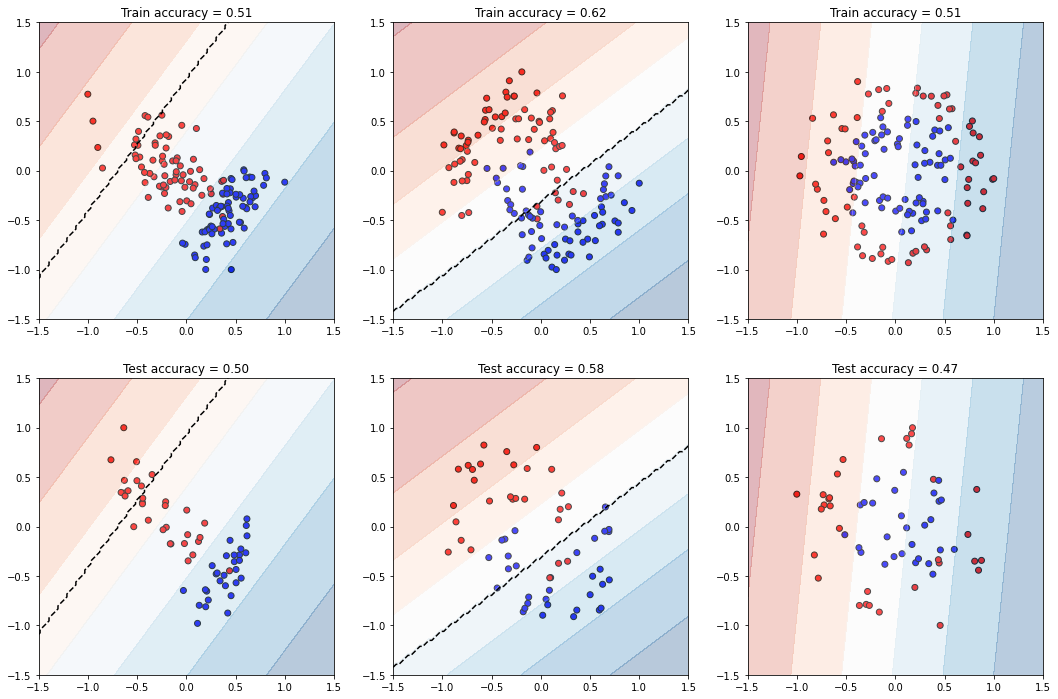

In [4]:
#@title Choose the parameter for C { run: "auto" }
c_value = "0.01" #@param ["0.01", "0.1", "1", "10", "100"]
clf_models = [SVC(kernel="linear", C=float(c_value) , probability=True, gamma='auto', random_state=0)]
learn_test_plot(clf_models)

## Gaussian kernel

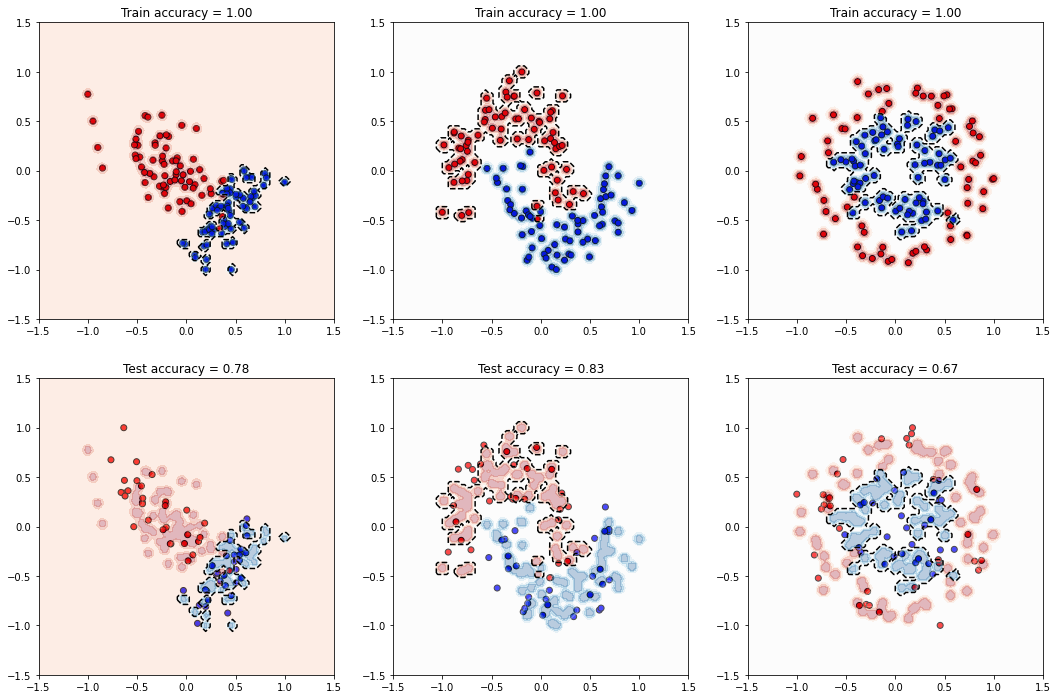

In [10]:
#@title Choose the size of the kenel { run: "auto" }
s = "0.001" #@param ["0.001", "0.01", "0.1", "1", "10", "100"]
c_values   = [i/100 for i in range(1,30000,1000)]
clf_models = [SVC(kernel="rbf", gamma=1/float(s), C=c, probability=True, random_state=0) for c in c_values]
learn_test_plot(clf_models)